In [2]:
pip install pandas numpy scikit-learn geopandas shapely fiona pyproj rtree xgboost


  Using cached geopandas-1.1.1-py3-none-any.whl.metadata (2.3 kB)
  Using cached rtree-1.4.1-py3-none-macosx_11_0_arm64.whl.metadata (2.1 kB)
  Using cached click_plugins-1.1.1.2-py2.py3-none-any.whl.metadata (6.5 kB)
  Using cached cligj-0.7.2-py3-none-any.whl.metadata (5.0 kB)
Using cached geopandas-1.1.1-py3-none-any.whl (338 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 48.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 32.9 MB/s eta 0:00:00
Using cached rtree-1.4.1-py3-none-macosx_11_0_arm64.whl (436 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 46.3 MB/s eta 0:00:00
Using cached click_plugins-1.1.1.2-py2.py3-none-any.whl (11 kB)
Using cached cligj-0.7.2-py3-none-any.whl (7.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 45.3 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9/9 [geopandas]/9 [geopandas]ins]


In [3]:
pip install dbfread

  Using cached dbfread-2.0.7-py2.py3-none-any.whl.metadata (3.3 kB)
Using cached dbfread-2.0.7-py2.py3-none-any.whl (20 kB)
Note: you may need to restart the kernel to use updated packages.


✅ Loaded dataset: 227428 samples
📍 Attaching REAL NYC borough boundaries...
🏙️ Matched: 181871 check-ins to boroughs
📊 Building soft-label distributions...
➡️ Created 835 unique contexts with probability distributions.
🧠 Training multi-output XGBoost Regressor...
✨ Validation MSE: 0.000324
Office                                      0.099868
Coffee Shop                                 0.038232
Gym / Fitness Center                        0.033689
Medical Center                              0.027905
College Academic Building                   0.026403
Government Building                         0.024270
Building                                    0.022836
Hotel                                       0.022143
Deli / Bodega                               0.019981
Subway                                      0.019463
Food & Drink Shop                           0.019290
Park                                        0.018844
Train Station                               0.018208
Bar                 

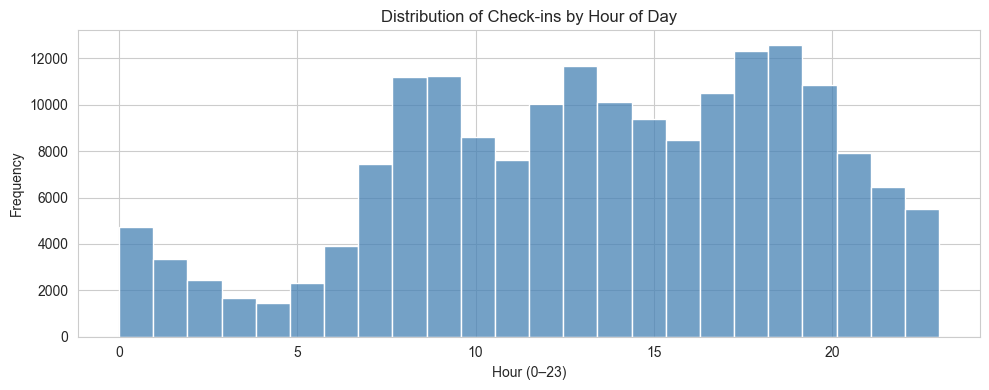

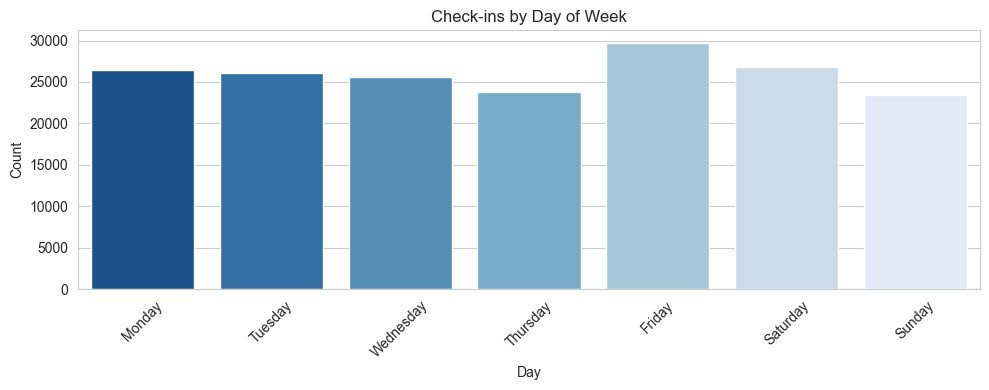

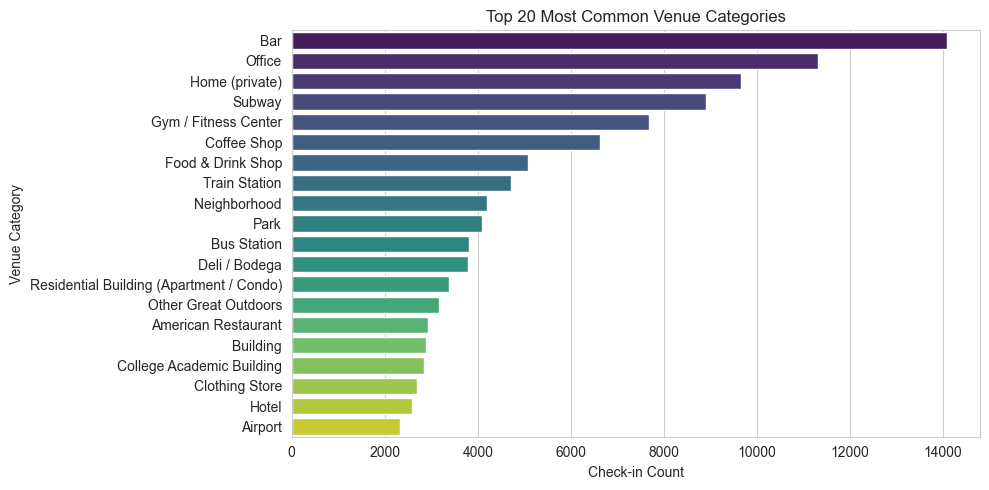

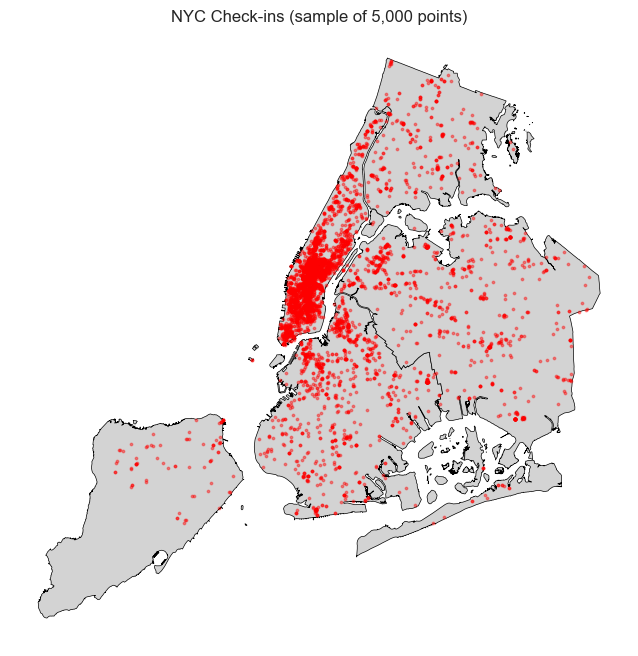

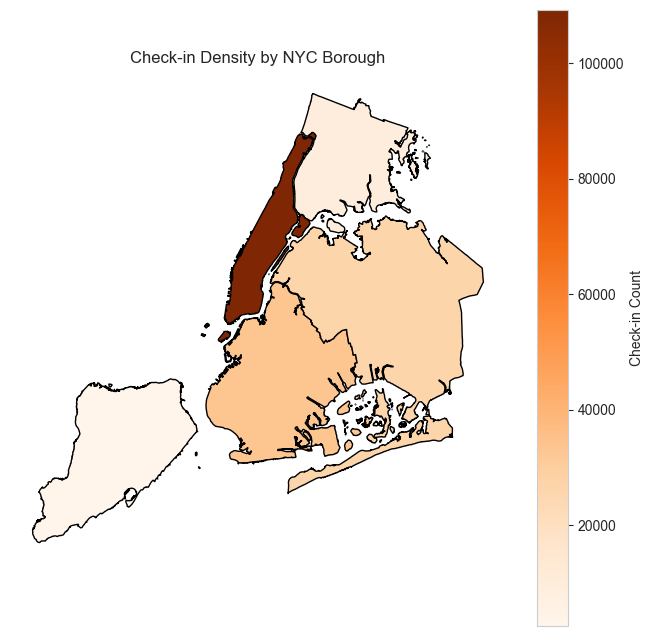

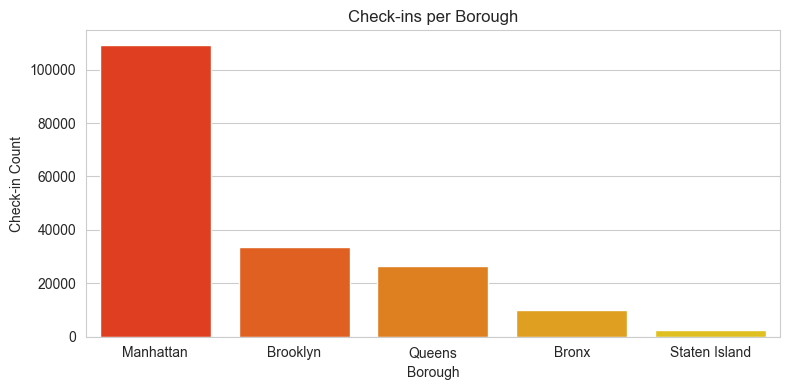

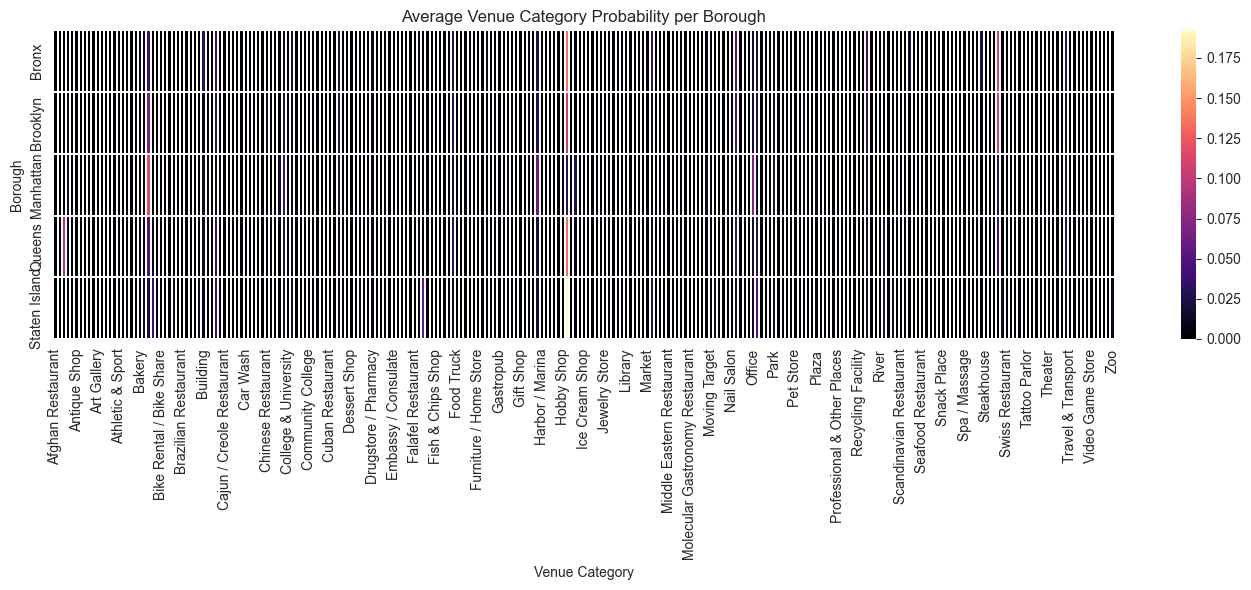

NameError: name 'model' is not defined

In [12]:
import warnings
from datetime import timedelta
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor
import geopandas as gpd
from shapely.geometry import Point

warnings.filterwarnings("ignore")

# 1. LOAD DATA

def load_raw_data():
    """
    Load the NYC Foursquare check-in dataset.
    """
    file_path = "/Users/chardog234/Documents/GitHub/Final_project_4003/dataset_TSMC2014_NYC.csv"
    df = pd.read_csv(file_path, encoding="ISO-8859-1")
    print(f"✅ Loaded dataset: {len(df)} samples")
    return df


# 2. NORMALIZE TIMES


def normalize_times(df):
    """
    Convert UTC timestamps to local time and extract:
      - Day_of_Week
      - Hour (0–23)
    """
    df = df.copy()

    df["UTC_Time"] = pd.to_datetime(
        df["utcTimestamp"],
        utc=True,
        format="%a %b %d %H:%M:%S +0000 %Y",
        errors="coerce"
    )

    # Drop invalid timestamps
    df = df.dropna(subset=["UTC_Time"])

    # Convert to local time using timezoneOffset (in minutes)
    df["Local_Time"] = df["UTC_Time"] + pd.to_timedelta(df["timezoneOffset"], unit="m")
    df["Day_of_Week"] = df["Local_Time"].dt.day_name()
    df["Hour"] = df["Local_Time"].dt.hour

    return df


# 3. ATTACH BOROUGH SHAPES

def attach_borough_zones(df):
    """
    Spatially join check-ins to real NYC borough polygons.
    Adds a 'Borough_ID' column containing the borough name.
    """
    print("📍 Attaching REAL NYC borough boundaries...")

    shp = "/Users/chardog234/Documents/GitHub/Final_project_4003/geo_export_3c9604c8-be29-4e21-ae16-9c7d64ebce63.shp"
    boroughs = gpd.read_file(shp).to_crs(epsg=4326)

    BOROUGH_COL = "boroname"  # confirmed from DBF

    # Convert (longitude, latitude) to geometry points
    gdf = gpd.GeoDataFrame(
        df.copy(),
        geometry=[Point(xy) for xy in zip(df["longitude"], df["latitude"])],
        crs="EPSG:4326"
    )

    # Spatial join: each check-in gets assigned a borough
    gdf_join = gpd.sjoin(
        gdf,
        boroughs[[BOROUGH_COL, "geometry"]],
        how="left",
        predicate="within"
    )

    gdf_join = gdf_join.rename(columns={BOROUGH_COL: "Borough_ID"})
    gdf_join = gdf_join.dropna(subset=["Borough_ID"])
    gdf_join = gdf_join.drop(columns=["geometry", "index_right"], errors="ignore")

    print(f"🏙️ Matched: {len(gdf_join)} check-ins to boroughs")
    return gdf_join


# 4. BUILD SOFT-LABEL CONTEXTS

def build_soft_contexts(df):
    """
    Build soft-label probability distributions for each context:
      Context = (Borough_ID, Day_of_Week, Hour)

    For each context, compute:
      P(venueCategory | borough, day, hour) = freq / total freq in that context

    Returns a pivoted DataFrame with:
      - columns: [Borough_ID, Day_of_Week, Hour, <venueCategory1>, <venueCategory2>, ...]
      - each venueCategory column = probability in that context
    """
    print("📊 Building soft-label distributions...")

    group_cols = ["Borough_ID", "Day_of_Week", "Hour"]

    # Count check-ins per (borough, day, hour, venueCategory)
    counts = (
        df.groupby(group_cols + ["venueCategory"])
          .size()
          .reset_index(name="freq")
    )

    # Normalize frequencies within each context → probabilities
    counts["prob"] = counts["freq"] / counts.groupby(group_cols)["freq"].transform("sum")

    # Pivot to wide format: 1 row per context, 1 column per venue category
    df_pivot = counts.pivot_table(
        index=group_cols,
        columns="venueCategory",
        values="prob",
        fill_value=0.0
    ).reset_index()

    print(f"➡️ Created {len(df_pivot)} unique contexts with probability distributions.")
    return df_pivot


# 5. MODEL (MULTI-OUTPUT REGRESSION)

class MovementModel:
    """
    Multi-output regression model that predicts
    P(venueCategory | borough, day, hour)
    as a probability distribution over categories.
    """

    def __init__(self):
        self.model = None
        self.enc_borough = LabelEncoder()
        self.enc_day = LabelEncoder()
        self.enc_hour = LabelEncoder()
        self.categories = None

    # --------------------------------------------------------
    def fit(self, df_ctx):
        """
        Fit the model on context-level probability distributions.
        """
        df = df_ctx.copy()

        # Identify all venue category columns (everything except the keys)
        self.categories = [c for c in df.columns if c not in ["Borough_ID", "Day_of_Week", "Hour"]]

        # Encode inputs
        df["borough_enc"] = self.enc_borough.fit_transform(df["Borough_ID"])
        df["day_enc"] = self.enc_day.fit_transform(df["Day_of_Week"])
        df["hour_enc"] = self.enc_hour.fit_transform(df["Hour"])

        X = df[["borough_enc", "day_enc", "hour_enc"]]
        Y = df[self.categories]

        X_train, X_test, Y_train, Y_test = train_test_split(
            X, Y, test_size=0.2, random_state=42
        )

        print("🧠 Training multi-output XGBoost Regressor...")
        base = XGBRegressor(
            objective="reg:squarederror",
            n_estimators=300,
            learning_rate=0.07,
            max_depth=8,
            subsample=0.9,
            colsample_bytree=0.9
        )

        self.model = MultiOutputRegressor(base)
        self.model.fit(X_train, Y_train)

        preds = self.model.predict(X_test)
        mse = mean_squared_error(Y_test.values.flatten(), preds.flatten())
        print(f"✨ Validation MSE: {mse:.6f}")

    # --------------------------------------------------------
    def predict_distribution(self, borough, day, hour, temperature=1.5):
        """
        Predict a smoothed probability distribution over venue categories
        for a given (borough, day, hour).

        temperature > 1.0 → softer probabilities (less peaky)
        """
        X = pd.DataFrame([{
            "borough_enc": self.enc_borough.transform([borough])[0],
            "day_enc": self.enc_day.transform([day])[0],
            "hour_enc": self.enc_hour.transform([hour])[0]
        }])

        raw = self.model.predict(X)[0]

        # Clip small negatives due to regression noise
        raw = np.maximum(raw, 0)

        # Temperature smoothing to avoid extremely sharp peaks
        raw = raw ** (1.0 / temperature)

        # Re-normalize to sum to 1
        total = raw.sum()
        if total == 0:
            # Fallback: uniform distribution if model is degenerate
            probs = np.ones_like(raw) / len(raw)
        else:
            probs = raw / total

        return pd.Series(probs, index=self.categories).sort_values(ascending=False)


# 6. MAIN SCRIPT (TEST RUN)


def main():
    # 1. Load and preprocess data
    df = load_raw_data()
    df = normalize_times(df)
    df = attach_borough_zones(df)

    # 2. Build soft probability contexts
    df_ctx = build_soft_contexts(df)

    # 3. Train model
    model = MovementModel()
    model.fit(df_ctx)

    # 4. Example prediction
    preds = model.predict_distribution("Manhattan", "Monday", 10, temperature=1.5)
    print(preds.head(15))


if __name__ == "__main__":
    main()




import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point

# LOAD + PREPROCESS (your funcs)

df = load_raw_data()
df = normalize_times(df)
df = attach_borough_zones(df)

# Convert to GeoDataFrame for maps
gdf = gpd.GeoDataFrame(
    df.copy(),
    geometry=[Point(xy) for xy in zip(df["longitude"], df["latitude"])],
    crs="EPSG:4326"
)

# -------------------------------
# 1. HISTOGRAM: CHECK-INS PER HOUR
# -------------------------------
plt.figure(figsize=(10, 4))
sns.histplot(df["Hour"], bins=24, kde=False, color="steelblue")
plt.title("Distribution of Check-ins by Hour of Day")
plt.xlabel("Hour (0–23)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


# -------------------------------
# 2. HISTOGRAM: CHECK-INS PER DAY OF WEEK
# -------------------------------
plt.figure(figsize=(10, 4))
order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
sns.countplot(data=df, x="Day_of_Week", order=order, palette="Blues_r")
plt.title("Check-ins by Day of Week")
plt.xlabel("Day")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# -------------------------------
# 3. HISTOGRAM: VENUE CATEGORY POPULARITY
# -------------------------------
plt.figure(figsize=(10, 5))
top_20 = df["venueCategory"].value_counts().head(20)
sns.barplot(x=top_20.values, y=top_20.index, palette="viridis")
plt.title("Top 20 Most Common Venue Categories")
plt.xlabel("Check-in Count")
plt.ylabel("Venue Category")
plt.tight_layout()
plt.show()


# -------------------------------
# 4. SIMPLE MAP: POINTS OVER NYC BOROUGHS
# -------------------------------
borough_shp = "/Users/chardog234/Documents/GitHub/Final_project_4003/geo_export_3c9604c8-be29-4e21-ae16-9c7d64ebce63.shp"
boroughs = gpd.read_file(borough_shp).to_crs(epsg=4326)

fig, ax = plt.subplots(figsize=(8, 8))
boroughs.plot(ax=ax, color="lightgray", edgecolor="black", linewidth=0.5)
gdf.sample(5000).plot(ax=ax, markersize=3, alpha=0.4, color="red")  # sample to keep map readable
plt.title("NYC Check-ins (sample of 5,000 points)")
plt.axis("off")
plt.show()


# -------------------------------
# 5. CHOROPLETH: CHECK-INS PER BOROUGH
# -------------------------------
borough_counts = df.groupby("Borough_ID").size().reset_index(name="count")
boroughs_plot = boroughs.merge(borough_counts, left_on="boroname", right_on="Borough_ID", how="left")
boroughs_plot["count"] = boroughs_plot["count"].fillna(0)

fig, ax = plt.subplots(figsize=(8, 8))
boroughs_plot.plot(
    ax=ax,
    column="count",
    cmap="Oranges",
    legend=True,
    legend_kwds={"label": "Check-in Count"},
    edgecolor="black"
)
plt.title("Check-in Density by NYC Borough")
plt.axis("off")
plt.show()


# -------------------------------
# 6. BAR CHART: CHECK-INS PER BOROUGH
# -------------------------------
plt.figure(figsize=(8, 4))
sns.barplot(data=borough_counts.sort_values("count", ascending=False),
            x="Borough_ID", y="count", palette="autumn")
plt.title("Check-ins per Borough")
plt.xlabel("Borough")
plt.ylabel("Check-in Count")
plt.tight_layout()
plt.show()


plt.figure(figsize=(14, 6))
sns.heatmap(ctx_heat, cmap="magma", linewidths=0.1)
plt.title("Average Venue Category Probability per Borough")
plt.xlabel("Venue Category")
plt.ylabel("Borough")
plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt
import seaborn as sns

TARGET_DAY = "Friday"
TARGET_HOUR = 21  # 9 PM

all_boroughs = model.enc_borough.classes_

print("Predicting top 5 categories for each borough at Friday 9 PM...\n")

borough_results = {}

for b in all_boroughs:
    preds = model.predict_distribution(
        borough=b,
        day=TARGET_DAY,
        hour=TARGET_HOUR,
        temperature=1.3
    )
    
    top5 = preds.head(5)
    borough_results[b] = top5
    print(f"----- {b} -----")
    print(top5, "\n")


# Plot charts
num_boroughs = len(all_boroughs)
plt.figure(figsize=(16, 4 * num_boroughs))

for i, b in enumerate(all_boroughs, 1):
    top5 = borough_results[b]

    plt.subplot(num_boroughs, 1, i)
    sns.barplot(x=top5.values, y=top5.index, palette="viridis")

    plt.title(f"Top 5 Predicted Venue Categories – {b}\nFriday @ 9 PM")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Venue Category")
    plt.xlim(0, top5.values.max() * 1.2)

plt.tight_layout()
plt.show()



Loaded 227428 rows.
Matched: 181871 rows to boroughs.
Context rows: 835
Validation MSE = 0.00031546605077699386

========== MODEL EVALUATION ==========
TRAIN MSE: 8.323496519563801e-05
TEST MSE: 0.00031546605077699386
TRAIN RMSE: 0.009123319856041331
TEST RMSE: 0.017761363989767055
MAE: 0.00496339861278875
R² (overall): 0.26802103500963914


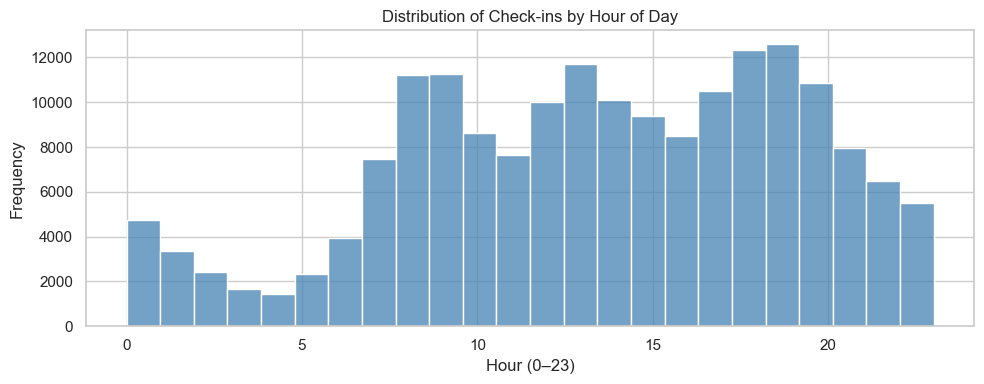

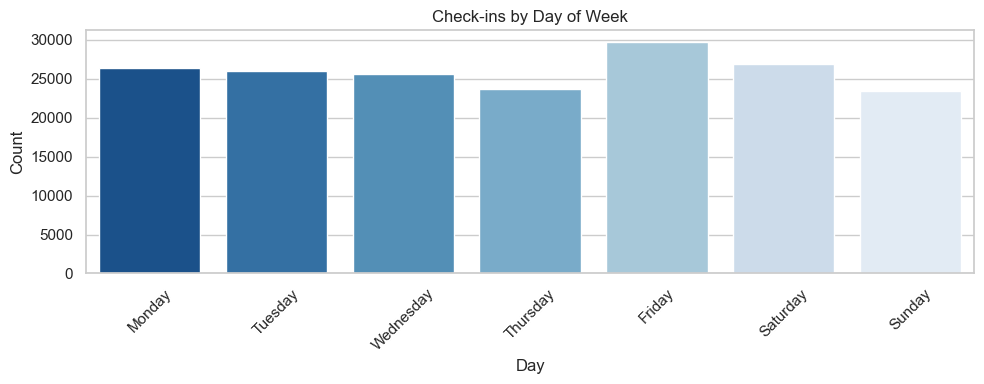

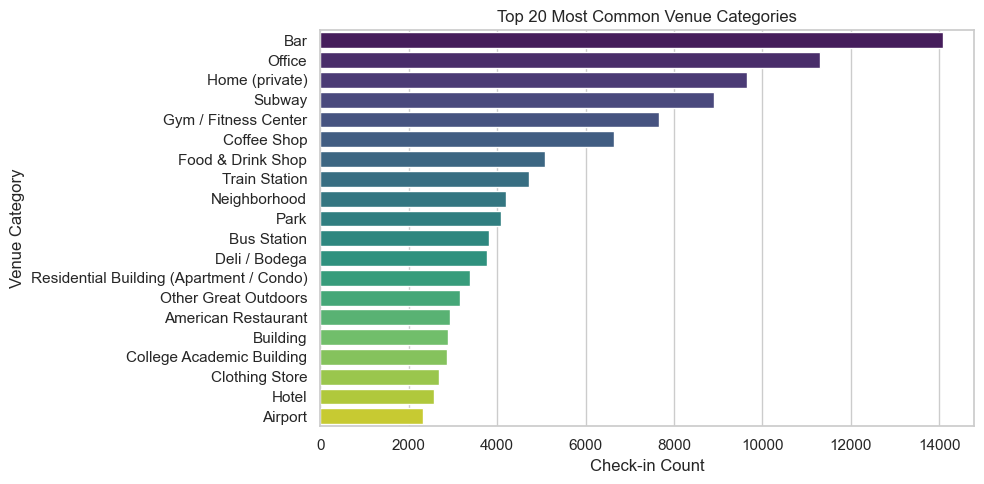

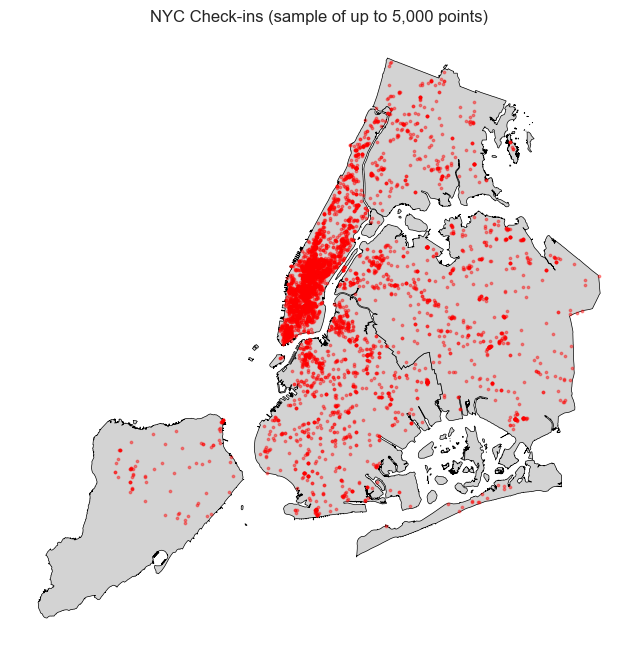

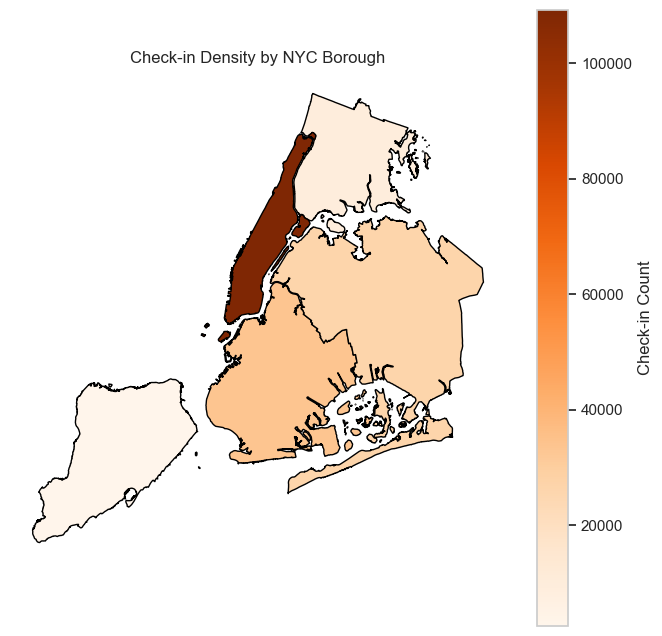

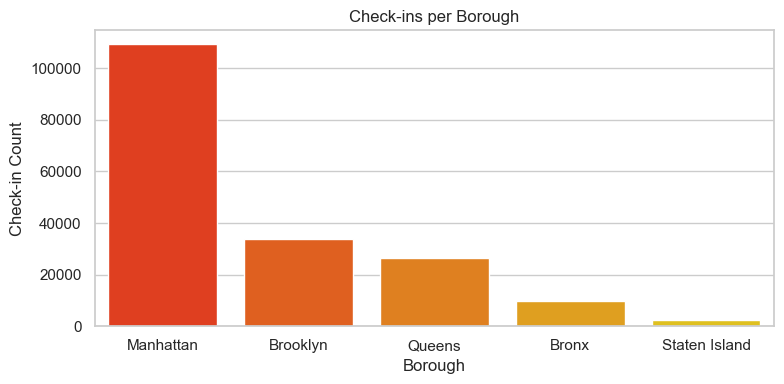

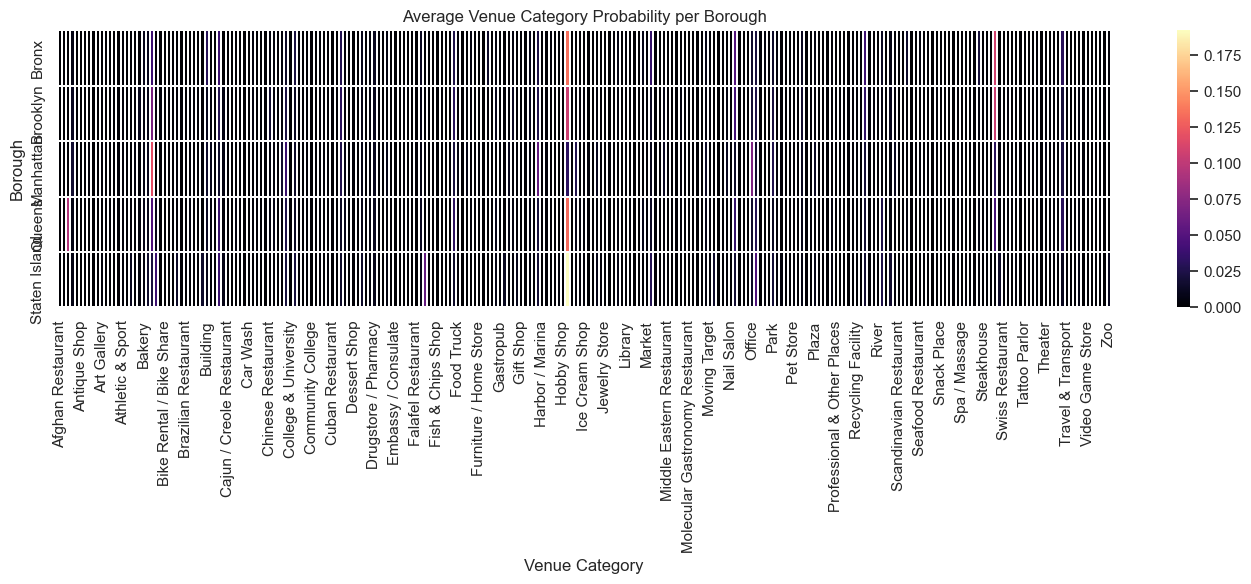

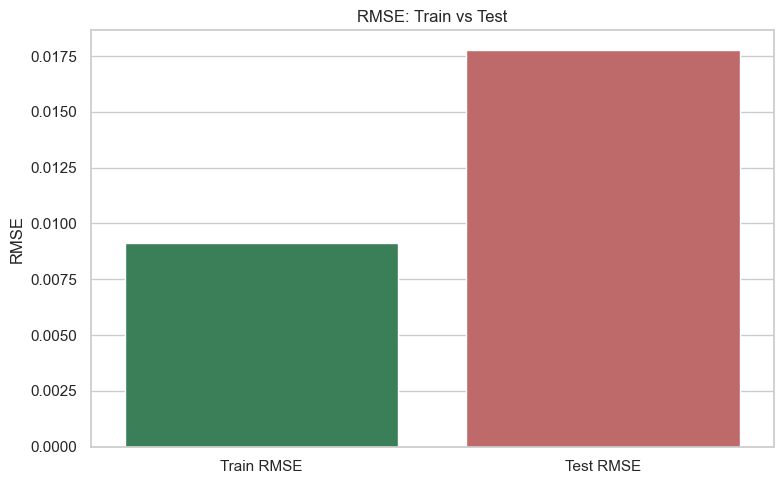

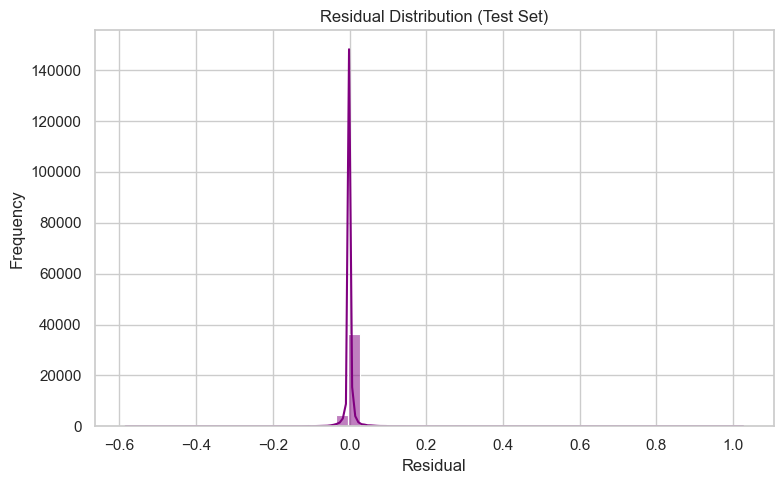

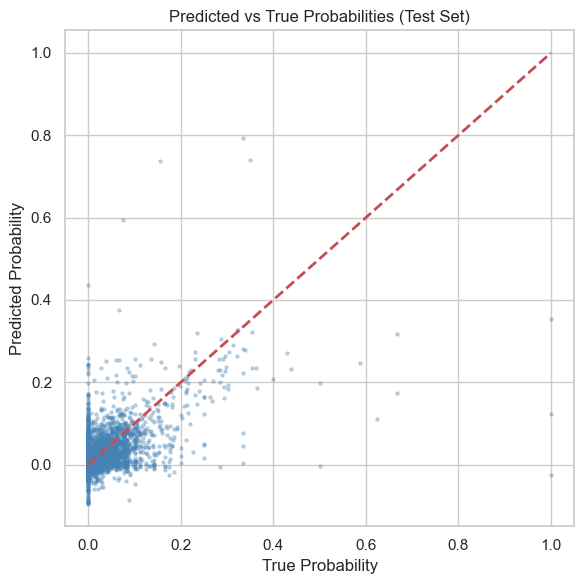

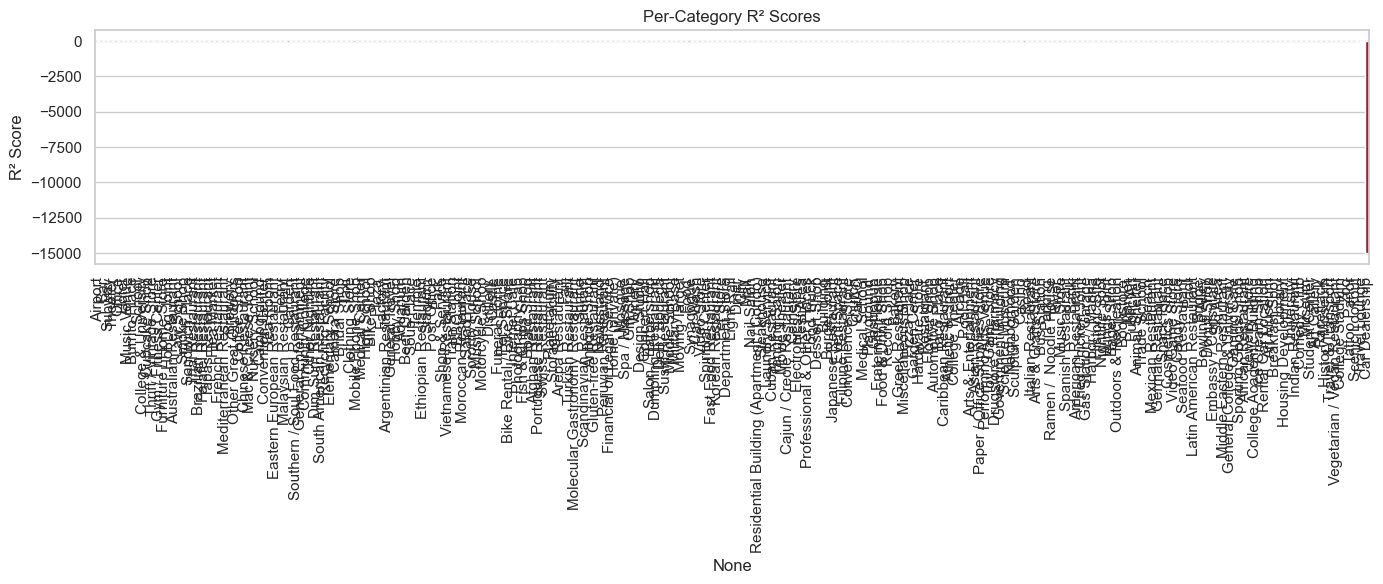

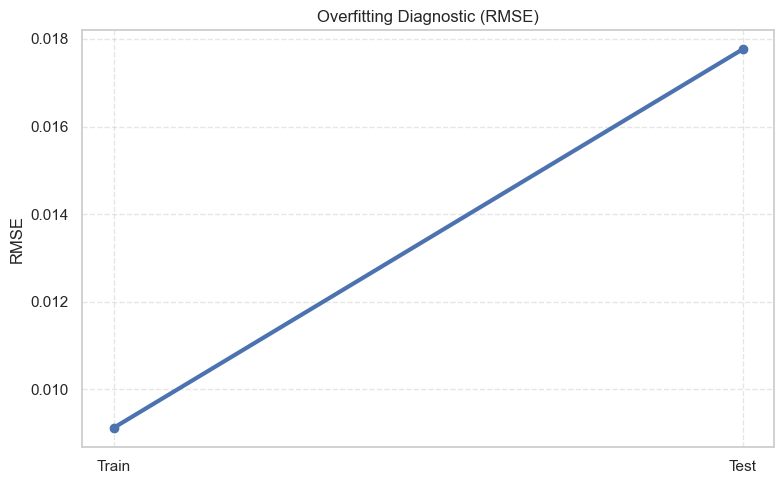

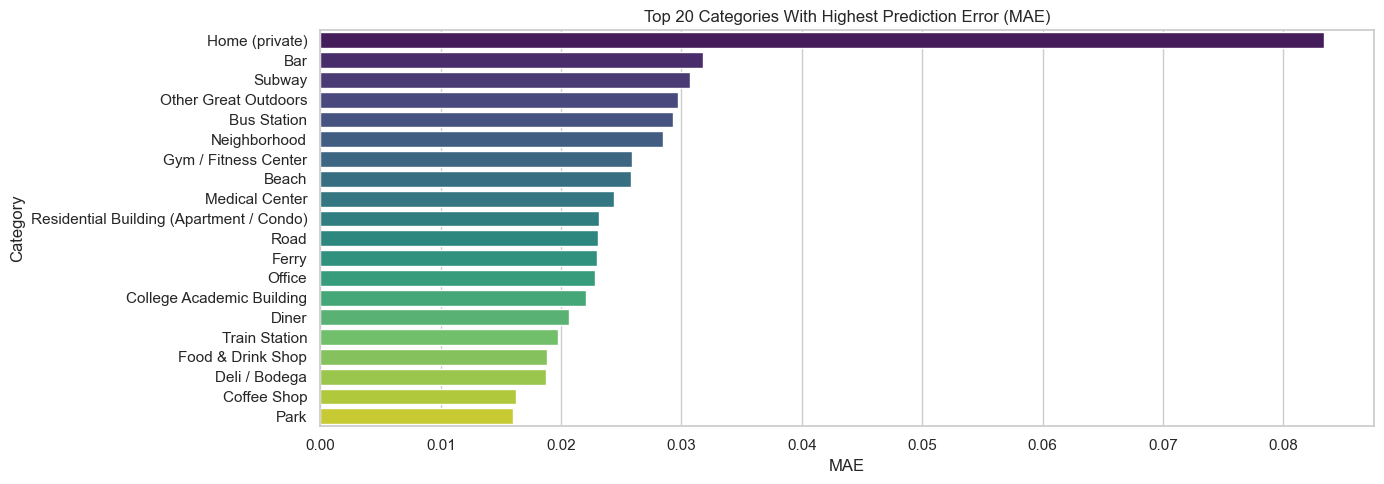


========== FRIDAY 9 PM – TOP 5 PREDICTED CATEGORIES PER BOROUGH ==========

Bronx
Home (private)    0.077502
Subway            0.068986
Bar               0.059176
Neighborhood      0.055267
Train Station     0.049245
dtype: float32

Brooklyn
Bar                                         0.101833
Residential Building (Apartment / Condo)    0.047409
Train Station                               0.041392
Home (private)                              0.040953
Neighborhood                                0.038888
dtype: float32

Manhattan
Bar                                         0.108898
Train Station                               0.048588
Residential Building (Apartment / Condo)    0.032985
Movie Theater                               0.032120
Mexican Restaurant                          0.031983
dtype: float32

Queens
Home (private)                              0.081365
Airport                                     0.064361
Bar                                         0.050972
Train Station      

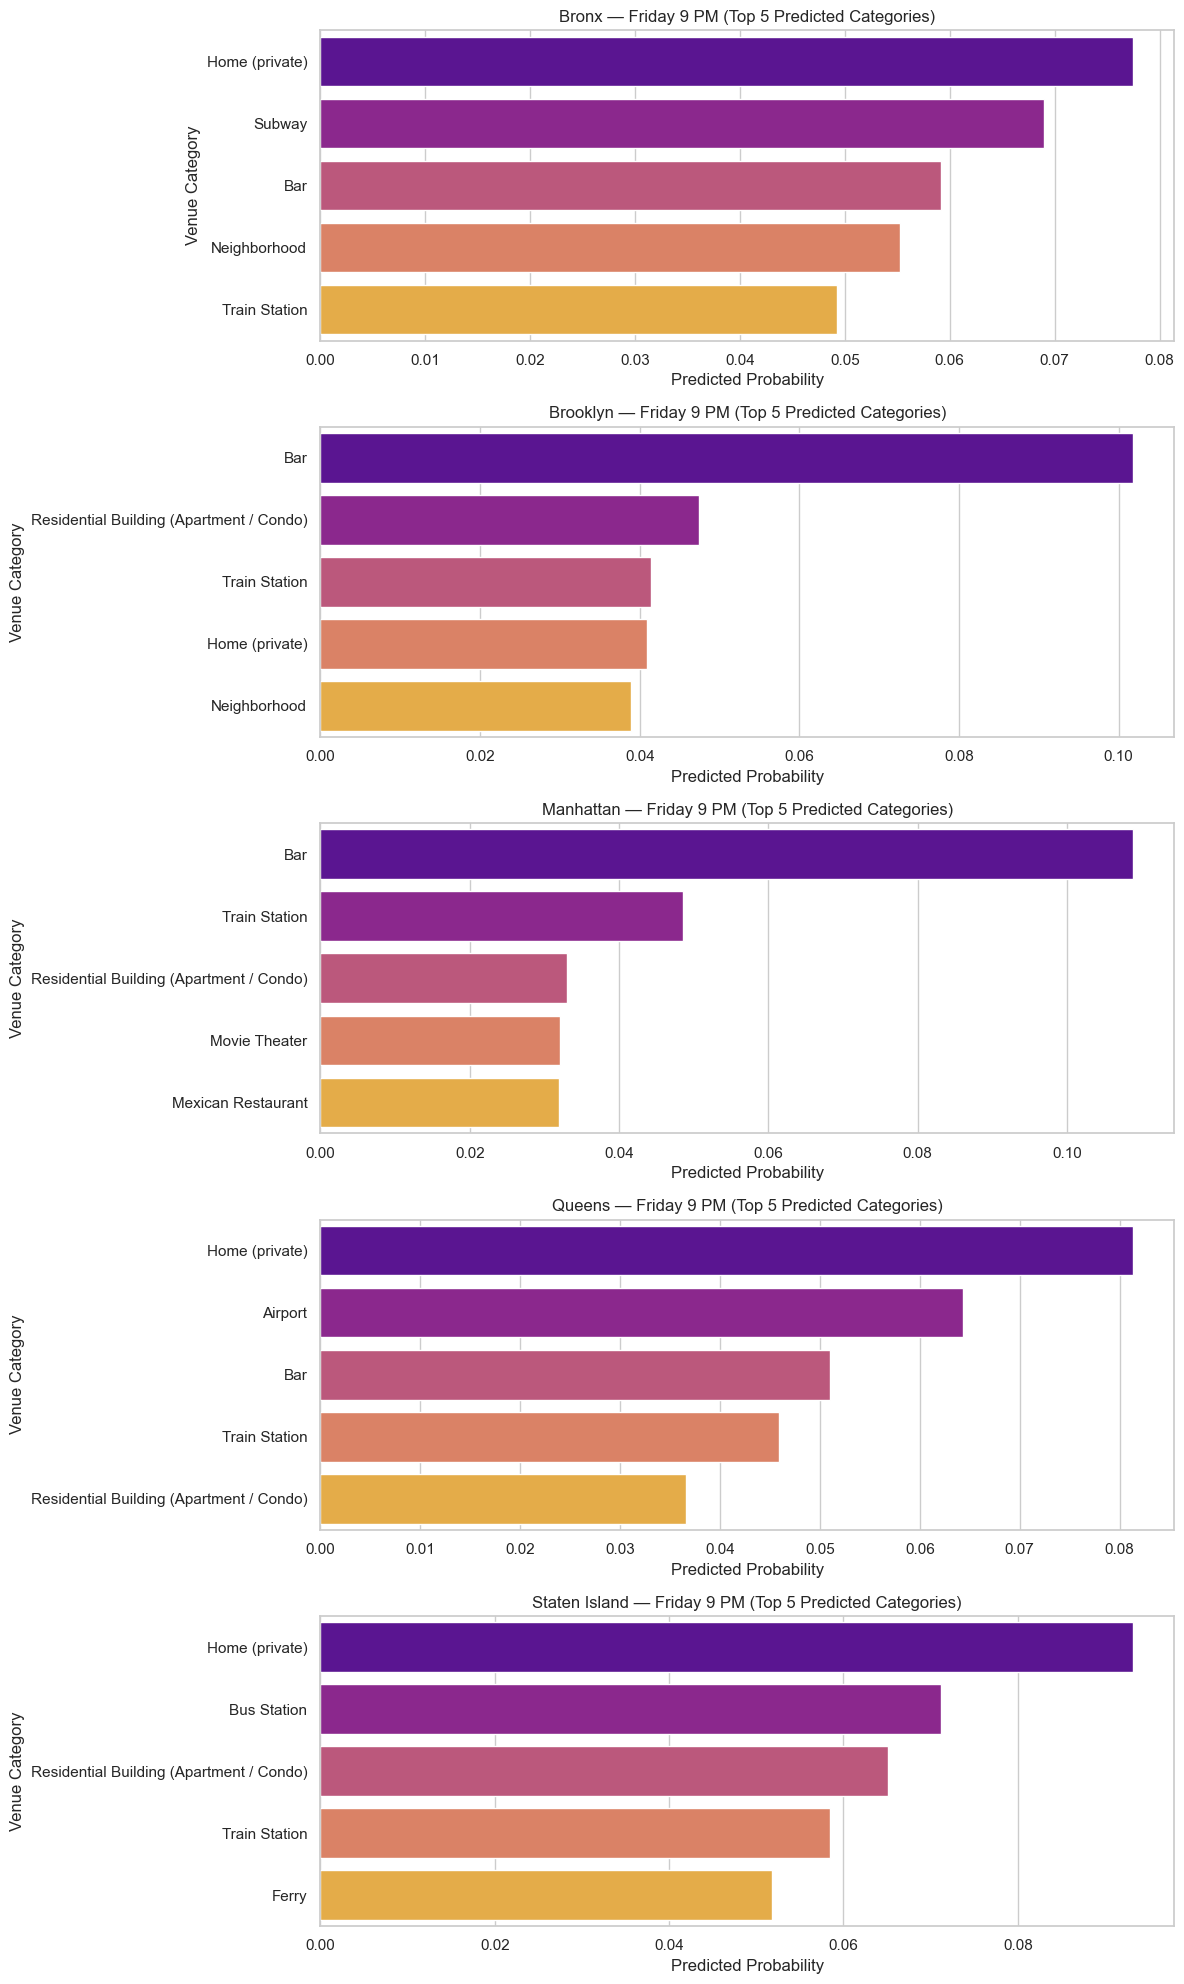

In [19]:
import warnings
warnings.filterwarnings("ignore")

# ============================================================
# Imports
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)

from xgboost import XGBRegressor

sns.set(style="whitegrid")

# ============================================================
# 1. LOAD RAW DATA
# ============================================================
def load_raw_data():
    fp = "/Users/chardog234/Documents/GitHub/Final_project_4003/dataset_TSMC2014_NYC.csv"
    df = pd.read_csv(fp, encoding="ISO-8859-1")
    print(f"Loaded {len(df)} rows.")
    return df


# ============================================================
# 2. NORMALIZE TIME
# ============================================================
def normalize_times(df):
    df = df.copy()

    df["UTC_Time"] = pd.to_datetime(
        df["utcTimestamp"],
        utc=True,
        format="%a %b %d %H:%M:%S +0000 %Y",
        errors="coerce"
    )

    df = df.dropna(subset=["UTC_Time"])

    # Local time = UTC + timezoneOffset (minutes)
    df["Local_Time"] = df["UTC_Time"] + pd.to_timedelta(df["timezoneOffset"], unit="m")
    df["Day_of_Week"] = df["Local_Time"].dt.day_name()
    df["Hour"] = df["Local_Time"].dt.hour

    return df


# ============================================================
# 3. ATTACH BOROUGH ZONES
# ============================================================
def attach_borough_zones(df):
    shp = "/Users/chardog234/Documents/GitHub/Final_project_4003/geo_export_3c9604c8-be29-4e21-ae16-9c7d64ebce63.shp"
    boroughs = gpd.read_file(shp).to_crs(epsg=4326)

    gdf = gpd.GeoDataFrame(
        df.copy(),
        geometry=[Point(xy) for xy in zip(df["longitude"], df["latitude"])],
        crs="EPSG:4326"
    )

    joined = gpd.sjoin(
        gdf,
        boroughs[["boroname", "geometry"]],
        how="left",
        predicate="within"
    )

    joined = joined.rename(columns={"boroname": "Borough_ID"})
    joined = joined.dropna(subset=["Borough_ID"])
    joined = joined.drop(columns=["index_right"])

    print("Matched:", len(joined), "rows to boroughs.")
    return joined, boroughs


# ============================================================
# 4. BUILD SOFT LABEL CONTEXTS
# ============================================================
def build_soft_contexts(df):
    group_cols = ["Borough_ID", "Day_of_Week", "Hour"]

    counts = (
        df.groupby(group_cols + ["venueCategory"])
        .size()
        .reset_index(name="freq")
    )

    counts["prob"] = counts["freq"] / counts.groupby(group_cols)["freq"].transform("sum")

    pivot = counts.pivot_table(
        index=group_cols,
        columns="venueCategory",
        values="prob",
        fill_value=0.0
    ).reset_index()

    print("Context rows:", len(pivot))
    return pivot


# ============================================================
# 5. MODEL
# ============================================================
class MovementModel:
    def __init__(self):
        self.model = None
        self.enc_borough = LabelEncoder()
        self.enc_day = LabelEncoder()
        self.enc_hour = LabelEncoder()
        self.categories = None

        # To store train/test + predictions for evaluation
        self.X_train = None
        self.X_test = None
        self.Y_train = None
        self.Y_test = None
        self.preds_train = None
        self.preds_test = None
        self.r2_per_category = None
        self.train_mse = None
        self.test_mse = None
        self.train_rmse = None
        self.test_rmse = None
        self.mae = None
        self.r2_overall = None

    def fit(self, df_ctx):
        df = df_ctx.copy()

        # All venue-category columns (targets)
        self.categories = [c for c in df.columns if c not in ["Borough_ID", "Day_of_Week", "Hour"]]

        # Encode inputs
        df["borough_enc"] = self.enc_borough.fit_transform(df["Borough_ID"])
        df["day_enc"] = self.enc_day.fit_transform(df["Day_of_Week"])
        df["hour_enc"] = self.enc_hour.fit_transform(df["Hour"])

        X = df[["borough_enc", "day_enc", "hour_enc"]]
        Y = df[self.categories]

        self.X_train, self.X_test, self.Y_train, self.Y_test = train_test_split(
            X, Y, test_size=0.2, random_state=42
        )

        base = XGBRegressor(
            objective="reg:squarederror",
            n_estimators=300,
            learning_rate=0.06,
            max_depth=8,
            subsample=0.85,
            colsample_bytree=0.9
        )

        self.model = MultiOutputRegressor(base)
        self.model.fit(self.X_train, self.Y_train)

        # Predictions for evaluation
        self.preds_train = self.model.predict(self.X_train)
        self.preds_test = self.model.predict(self.X_test)

        # Flatten for global metrics
        y_train_flat = self.Y_train.values.flatten()
        y_test_flat = self.Y_test.values.flatten()
        yhat_train_flat = self.preds_train.flatten()
        yhat_test_flat = self.preds_test.flatten()

        self.train_mse = mean_squared_error(y_train_flat, yhat_train_flat)
        self.test_mse = mean_squared_error(y_test_flat, yhat_test_flat)
        self.train_rmse = self.train_mse ** 0.5
        self.test_rmse = self.test_mse ** 0.5
        self.mae = mean_absolute_error(y_test_flat, yhat_test_flat)
        self.r2_overall = r2_score(y_test_flat, yhat_test_flat)

        # Per-category R²
        r2_vals = []
        for i, cat in enumerate(self.categories):
            r2_vals.append(
                r2_score(self.Y_test.iloc[:, i], self.preds_test[:, i])
            )
        self.r2_per_category = pd.Series(r2_vals, index=self.categories)

        print(f"Validation MSE = {self.test_mse}")
        print("\n========== MODEL EVALUATION ==========")
        print("TRAIN MSE:", self.train_mse)
        print("TEST MSE:", self.test_mse)
        print("TRAIN RMSE:", self.train_rmse)
        print("TEST RMSE:", self.test_rmse)
        print("MAE:", self.mae)
        print("R² (overall):", self.r2_overall)

    def predict_distribution(self, borough, day, hour, temperature=1.5):
        X = pd.DataFrame([{
            "borough_enc": self.enc_borough.transform([borough])[0],
            "day_enc": self.enc_day.transform([day])[0],
            "hour_enc": self.enc_hour.transform([hour])[0]
        }])

        raw = self.model.predict(X)[0]
        raw = np.maximum(raw, 0)
        raw = raw ** (1.0 / temperature)
        raw = raw / raw.sum()

        return pd.Series(raw, index=self.categories).sort_values(ascending=False)


# ============================================================
# 6. FULL PIPELINE
# ============================================================
# Load + preprocess
df = load_raw_data()
df = normalize_times(df)
df, boroughs = attach_borough_zones(df)

# For maps
gdf = gpd.GeoDataFrame(
    df.copy(),
    geometry=[Point(xy) for xy in zip(df["longitude"], df["latitude"])],
    crs="EPSG:4326"
)

# Build context-level soft labels
df_ctx = build_soft_contexts(df)

# Train model
model = MovementModel()
model.fit(df_ctx)

# Shortcuts for evaluation variables
Y_train = model.Y_train
Y_test = model.Y_test
preds_train = model.preds_train
preds_test = model.preds_test
r2_per_category = model.r2_per_category

# ============================================================
# 7. DISTRIBUTION VISUALIZATIONS (EDA)
# ============================================================

# -------------------------------
# 7.1 HISTOGRAM: CHECK-INS PER HOUR
# -------------------------------
plt.figure(figsize=(10, 4))
sns.histplot(df["Hour"], bins=24, kde=False, color="steelblue")
plt.title("Distribution of Check-ins by Hour of Day")
plt.xlabel("Hour (0–23)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# -------------------------------
# 7.2 HISTOGRAM: CHECK-INS PER DAY OF WEEK
# -------------------------------
plt.figure(figsize=(10, 4))
order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
sns.countplot(data=df, x="Day_of_Week", order=order, palette="Blues_r")
plt.title("Check-ins by Day of Week")
plt.xlabel("Day")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# -------------------------------
# 7.3 HISTOGRAM: VENUE CATEGORY POPULARITY
# -------------------------------
plt.figure(figsize=(10, 5))
top_20 = df["venueCategory"].value_counts().head(20)
sns.barplot(x=top_20.values, y=top_20.index, palette="viridis")
plt.title("Top 20 Most Common Venue Categories")
plt.xlabel("Check-in Count")
plt.ylabel("Venue Category")
plt.tight_layout()
plt.show()

# -------------------------------
# 7.4 SIMPLE MAP: POINTS OVER NYC BOROUGHS
# -------------------------------
fig, ax = plt.subplots(figsize=(8, 8))
boroughs.to_crs(epsg=4326).plot(ax=ax, color="lightgray", edgecolor="black", linewidth=0.5)
# sample to keep map readable
gdf.sample(min(5000, len(gdf))).plot(ax=ax, markersize=3, alpha=0.4, color="red")
plt.title("NYC Check-ins (sample of up to 5,000 points)")
plt.axis("off")
plt.show()

# -------------------------------
# 7.5 CHOROPLETH: CHECK-INS PER BOROUGH
# -------------------------------
borough_counts = df.groupby("Borough_ID").size().reset_index(name="count")
boroughs_plot = boroughs.merge(
    borough_counts,
    left_on="boroname",
    right_on="Borough_ID",
    how="left"
)
boroughs_plot["count"] = boroughs_plot["count"].fillna(0)

fig, ax = plt.subplots(figsize=(8, 8))
boroughs_plot.to_crs(epsg=4326).plot(
    ax=ax,
    column="count",
    cmap="Oranges",
    legend=True,
    legend_kwds={"label": "Check-in Count"},
    edgecolor="black"
)
plt.title("Check-in Density by NYC Borough")
plt.axis("off")
plt.show()

# -------------------------------
# 7.6 BAR CHART: CHECK-INS PER BOROUGH
# -------------------------------
plt.figure(figsize=(8, 4))
sns.barplot(
    data=borough_counts.sort_values("count", ascending=False),
    x="Borough_ID", y="count", palette="autumn"
)
plt.title("Check-ins per Borough")
plt.xlabel("Borough")
plt.ylabel("Check-in Count")
plt.tight_layout()
plt.show()

# -------------------------------
# 7.7 CONTEXT-LEVEL HEATMAP (MEAN P(category | borough))
# -------------------------------
ctx_heat = (
    df_ctx.groupby("Borough_ID")[df_ctx.columns[3:]]  # skip keys
    .mean()
)

plt.figure(figsize=(14, 6))
sns.heatmap(ctx_heat, cmap="magma", linewidths=0.1)
plt.title("Average Venue Category Probability per Borough")
plt.xlabel("Venue Category")
plt.ylabel("Borough")
plt.tight_layout()
plt.show()


# ============================================================
# 8. EVALUATION METRIC VISUALIZATIONS
# ============================================================

# 8.1 BASIC MSE / RMSE SUMMARY BAR CHART
train_mse = model.train_mse
test_mse = model.test_mse
train_rmse = model.train_rmse
test_rmse = model.test_rmse

plt.figure(figsize=(8, 5))
sns.barplot(
    x=["Train RMSE", "Test RMSE"],
    y=[train_rmse, test_rmse],
    palette=["seagreen", "indianred"]
)
plt.title("RMSE: Train vs Test")
plt.ylabel("RMSE")
plt.tight_layout()
plt.show()

# 8.2 RESIDUAL DISTRIBUTION (Test)
residuals = (Y_test.values.flatten() - preds_test.flatten())

plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=50, kde=True, color="purple")
plt.title("Residual Distribution (Test Set)")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# 8.3 SCATTER PLOT: TRUE vs PREDICTED (Test)
plt.figure(figsize=(6, 6))
plt.scatter(
    Y_test.values.flatten(),
    preds_test.flatten(),
    s=5,
    alpha=0.3,
    color="steelblue"
)

plt.plot([0, 1], [0, 1], "r--", lw=2)
plt.title("Predicted vs True Probabilities (Test Set)")
plt.xlabel("True Probability")
plt.ylabel("Predicted Probability")
plt.tight_layout()
plt.show()

# 8.4 PER-CATEGORY R² BAR CHART
r2_sorted = r2_per_category.sort_values(ascending=False)

plt.figure(figsize=(14, 6))
sns.barplot(
    x=r2_sorted.index,
    y=r2_sorted.values,
    palette="coolwarm"
)
plt.xticks(rotation=90)
plt.title("Per-Category R² Scores")
plt.ylabel("R² Score")
plt.tight_layout()
plt.show()

# 8.5 OVERFITTING DIAGNOSTIC CURVE (RMSE)
plt.figure(figsize=(8, 5))
plt.plot(["Train", "Test"], [train_rmse, test_rmse], marker="o", linewidth=3)
plt.title("Overfitting Diagnostic (RMSE)")
plt.ylabel("RMSE")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# 8.6 MAE BY CATEGORY (TOP 20 HARDEST)
mae_by_category = np.mean(np.abs(Y_test.values - preds_test), axis=0)
mae_df = pd.DataFrame({
    "Category": model.categories,
    "MAE": mae_by_category
}).sort_values("MAE", ascending=False)

plt.figure(figsize=(14, 5))
sns.barplot(data=mae_df.head(20), x="MAE", y="Category", palette="viridis")
plt.title("Top 20 Categories With Highest Prediction Error (MAE)")
plt.tight_layout()
plt.show()


# ============================================================
# 9. PREDICTION VISUALIZATION – FRIDAY 9 PM
# ============================================================
TARGET_DAY = "Friday"
TARGET_HOUR = 21  # 9 PM

all_boroughs = model.enc_borough.classes_

borough_results = {}
print("\n========== FRIDAY 9 PM – TOP 5 PREDICTED CATEGORIES PER BOROUGH ==========")
for b in all_boroughs:
    pred = model.predict_distribution(b, TARGET_DAY, TARGET_HOUR, temperature=1.2)
    borough_results[b] = pred.head(5)
    print(f"\n{b}")
    print(pred.head(5))

plt.figure(figsize=(12, 4 * len(all_boroughs)))

for i, b in enumerate(all_boroughs, 1):
    plt.subplot(len(all_boroughs), 1, i)
    top5 = borough_results[b]
    sns.barplot(x=top5.values, y=top5.index, palette="plasma")
    plt.title(f"{b} — Friday 9 PM (Top 5 Predicted Categories)")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Venue Category")

plt.tight_layout()
plt.show()


Loaded 227428 rows.
Matched: 181871 rows to boroughs.
Original #categories: 251
Grouped into: 31 categories (incl. 'Other').
Context rows: 835

========== MODEL EVALUATION ==========
TRAIN MSE: 1.8607569905943023e-06
TEST MSE: 0.0015568482960376347
TRAIN RMSE: 0.0013640956676840164
TEST RMSE: 0.03945691696062472
MAE: 0.017317713880758305
R² (overall): 0.6717069112003783


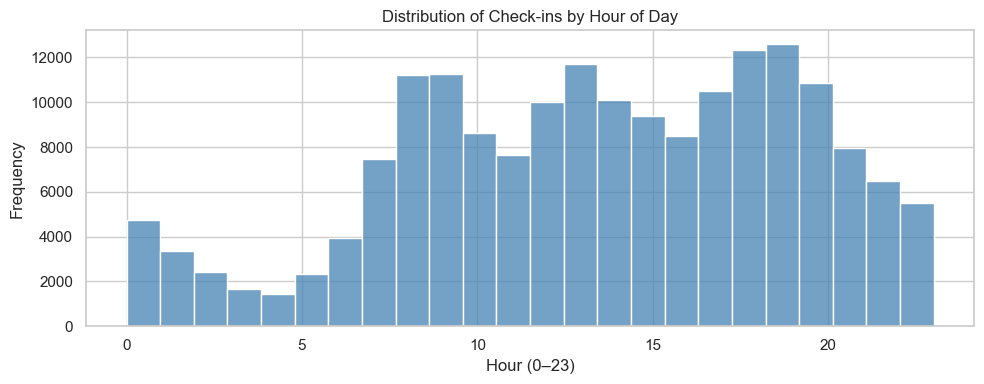

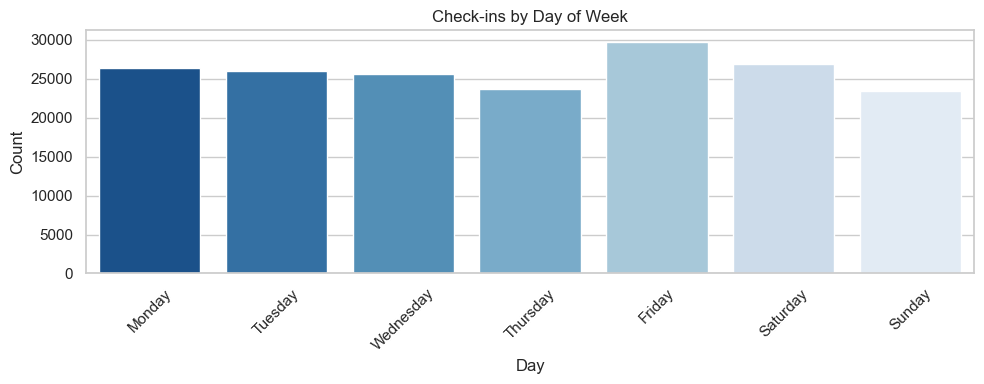

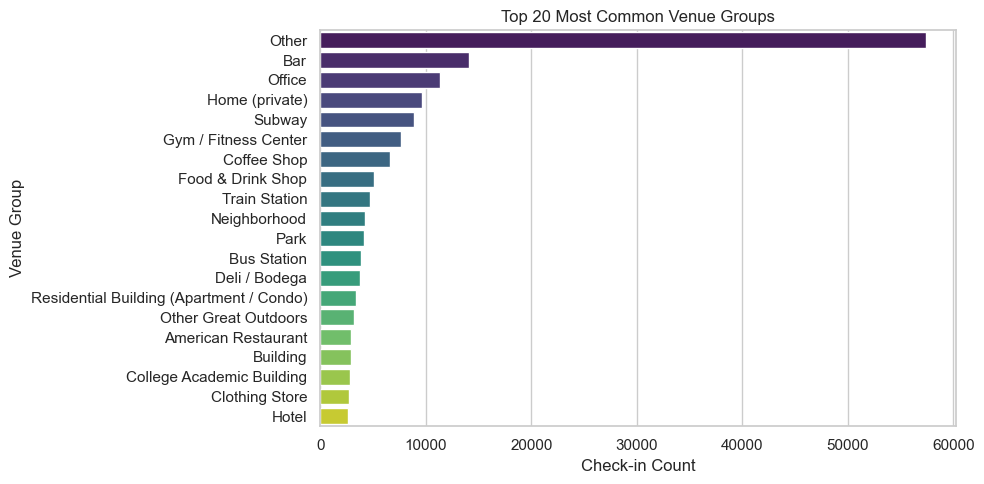

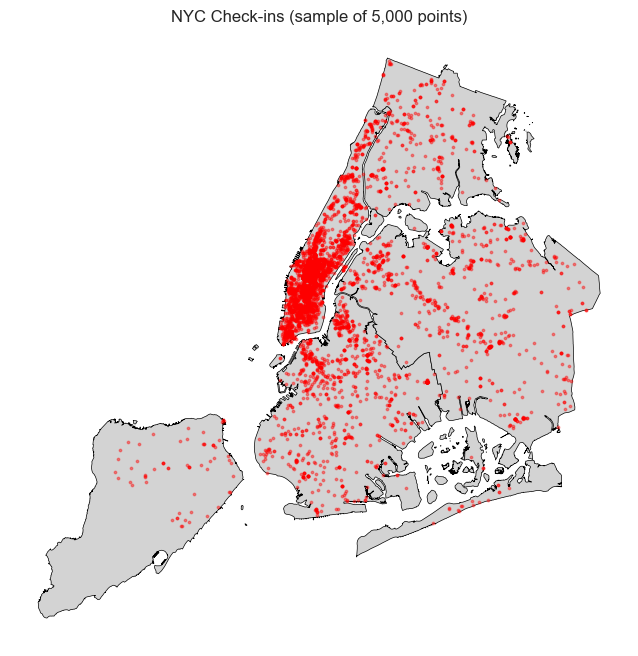

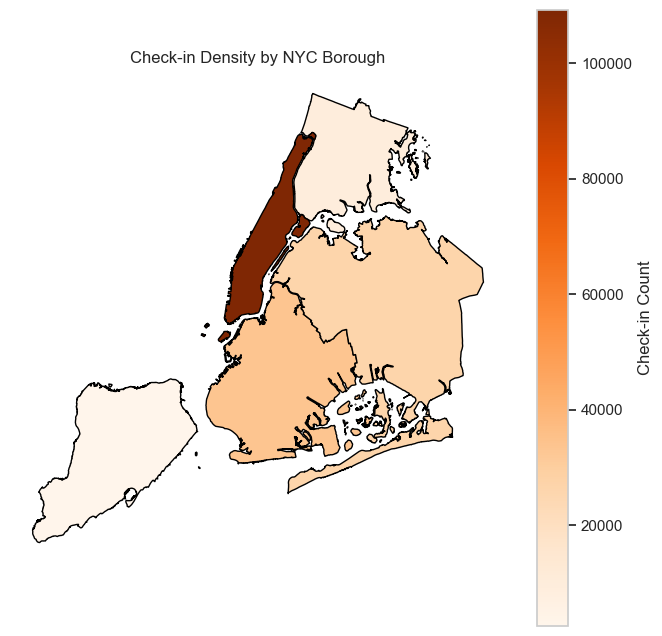

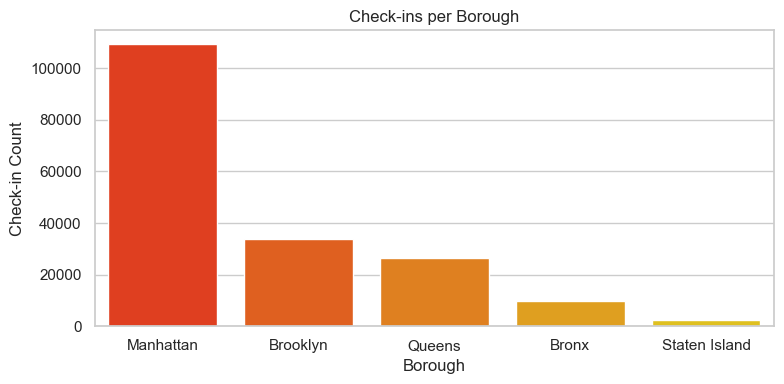


========== METRICS SUMMARY ==========
TRAIN MSE: 1.8607569905943023e-06
TEST MSE: 0.0015568482960376347
TRAIN RMSE: 0.0013640956676840164
TEST RMSE: 0.03945691696062472
MAE: 0.017317713880758305
R² (overall): 0.6717069112003783


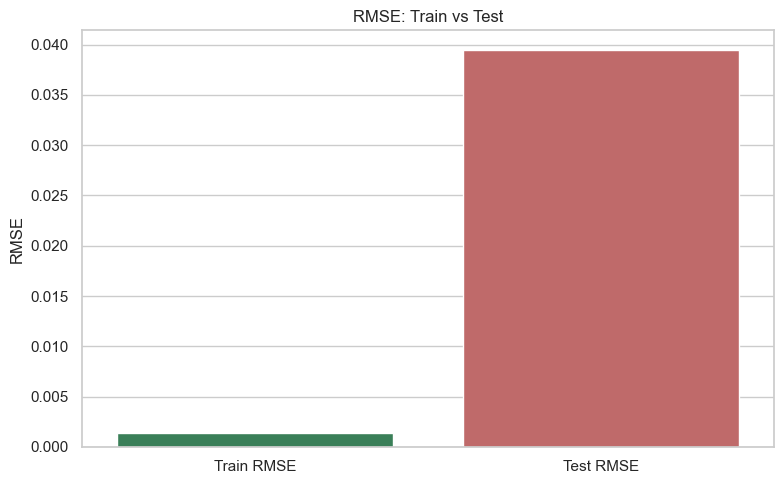

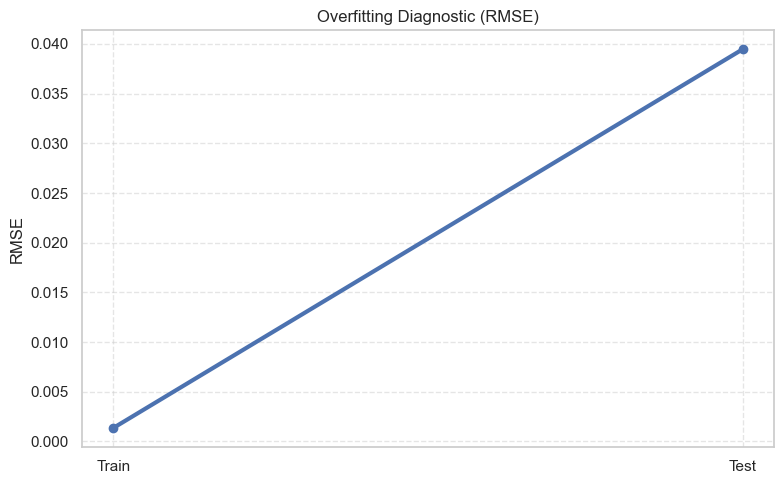

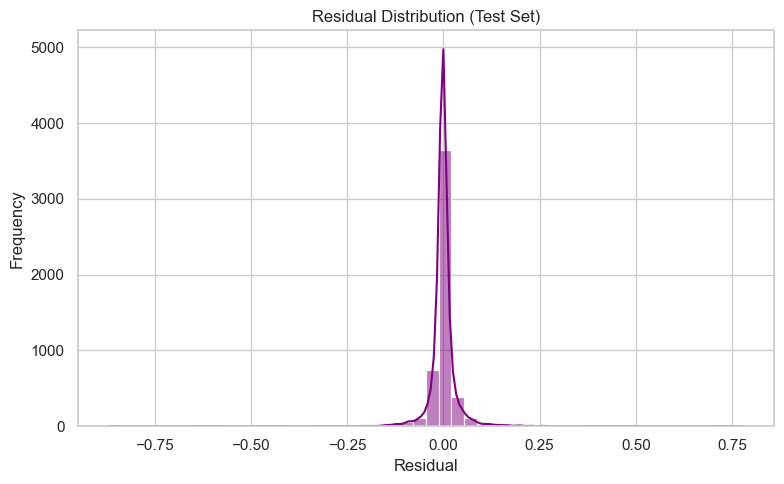

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# ============================================================
# Imports
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)

from xgboost import XGBRegressor

sns.set(style="whitegrid")


# 1. LOAD RAW DATA

def load_raw_data():
    fp = "/Users/chardog234/Documents/GitHub/Final_project_4003/dataset_TSMC2014_NYC.csv"
    df = pd.read_csv(fp, encoding="ISO-8859-1")
    print(f"Loaded {len(df)} rows.")
    return df


# 2. NORMALIZE TIME


def normalize_times(df):
    df = df.copy()

    df["UTC_Time"] = pd.to_datetime(
        df["utcTimestamp"],
        utc=True,
        format="%a %b %d %H:%M:%S +0000 %Y",
        errors="coerce"
    )

    df = df.dropna(subset=["UTC_Time"])

    # NOTE: timezoneOffset is in minutes; dataset appears to be local = UTC + offset
    df["Local_Time"] = df["UTC_Time"] + pd.to_timedelta(df["timezoneOffset"], unit="m") #basically adds the timezone offset to the UTC time 
    #to get local time or eastern timezone
    df["Day_of_Week"] = df["Local_Time"].dt.day_name()
    df["Hour"] = df["Local_Time"].dt.hour

    return df


# 3. ATTACH BOROUGH ZONES


def attach_borough_zones(df):
    shp = "/Users/chardog234/Documents/GitHub/Final_project_4003/geo_export_3c9604c8-be29-4e21-ae16-9c7d64ebce63.shp" #load shapefile
    boroughs = gpd.read_file(shp).to_crs(epsg=4326) #convert coordinate system to EPSG:4326 which is used by foursquare
#here we convert the checkins into a geodataframe so we can perform spatial analysis like joins
    gdf = gpd.GeoDataFrame( 
        df.copy(), #make a copy to not overwrite original 
        geometry=[Point(xy) for xy in zip(df["longitude"], df["latitude"])], #essentially creates the geometry column of the geodataframe 
        #using the longitude and latitude columns from the original dataframe 
        crs="EPSG:4326" #coordinate systems 
    ) 
#this is our spatial join where we match the checkin points to the borough polygons
    joined = gpd.sjoin(
        gdf,  #first takes in our geodatagrame of checkins
        boroughs[["boroname", "geometry"]], #joins each points to each borough polygon based on location
        how="left", #basically all the points that don't match to a borough will be NaN, we ended up with a lot that didn't match, 
        #pretty sure foursqaure included points outside of NYC
        predicate="within" #this is the type of spatial join we are doing, within means we are looking for points within polygons obviously
    )

    joined = joined.rename(columns={"boroname": "Borough_ID"}) #rename
    joined = joined.dropna(subset=["Borough_ID"]) #Removes all NAN rows, takes away all points that werent in the borough boundary
    joined = joined.drop(columns=["index_right"]) #drop unnecessary column from spatial join

    print("Matched:", len(joined), "rows to boroughs.") #Prints to show how many points were matched to boroughs
    return joined, boroughs #Return the joined dataframe and the boroughs polygon layer


# 4. CATEGORY SIMPLIFICATION  (#1 + #5)


def simplify_categories(df, top_xamount=30, min_count=50):
    #make copy to not overwrite original
    df = df.copy() 
    #literally just counting how many times each category appears
    venueCount = df["venueCategory"].value_counts() 
    # here we create a variable named frequent that first removes all categories that appear less than 50 times(min_count)
    # then we take the most frequent of of those, set at 30 or top_xamount
    frequent = venueCount[venueCount >= min_count].head(top_xamount).index 
    #Add a new column to the dataframe where if the category is in the frequent list we keep it, otherwise we set it as Other
    df["venueCategory_grouped"] = df["venueCategory"].where(
        df["venueCategory"].isin(frequent),
        other="Other"
    )
    #Just printing the number of original categories vs the new grouped categories
    print(f"Original #categories: {df['venueCategory'].nunique()}")
    print(f"Grouped into: {df['venueCategory_grouped'].nunique()} categories (incl. 'Other').")

    return df


# ============================================================
# 5. BUILD SOFT LABEL CONTEXTS  (#9 smoothing)
# ============================================================
def build_soft_contexts(df, category_col="venueCategory_grouped", alpha=0.3):
   #build out a context
    group_cols = ["Borough_ID", "Day_of_Week", "Hour"]

    counts = (
        df.groupby(group_cols + [category_col])
          .size()
          .reset_index(name="freq")
    )

    # Laplace smoothing
    counts["freq_smoothed"] = counts["freq"] + alpha
    counts["prob"] = counts["freq_smoothed"] / counts.groupby(group_cols)["freq_smoothed"].transform("sum")

    pivot = counts.pivot_table(
        index=group_cols,
        columns=category_col,
        values="prob",
        fill_value=0.0
    ).reset_index()

    print("Context rows:", len(pivot))
    return pivot


# ============================================================
# 6. MODEL (OneHot + tuned XGB + stratified split)
# ============================================================
class MovementModel:
    def __init__(self):
        self.model = None
        self.ohe = None
        self.categories = None

    def fit(self, df_ctx):
        """
        - OneHot encode input features (#3)
        - Stratified train/test split by borough (#6)
        - Bigger/tuned XGBoost model (#4)
        - Compute evaluation metrics
        """
        df = df_ctx.copy()

        keys = ["Borough_ID", "Day_of_Week", "Hour"]
        self.categories = [c for c in df.columns if c not in keys]

        X_raw = df[keys]
        Y = df[self.categories]

        # One-hot encode the categorical inputs
        self.ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
        X_all = self.ohe.fit_transform(X_raw)

        # stratify by borough so every borough is in both train and test
        strat_labels = X_raw["Borough_ID"]

        global X_train, X_test, Y_train, Y_test
        global preds_train, preds_test, r2_per_category, overall_r2

        X_train, X_test, Y_train, Y_test = train_test_split(
            X_all,
            Y,
            test_size=0.2,
            random_state=42,
            stratify=strat_labels
        )

        # Tuned XGBoost (#4)
        base = XGBRegressor(
            objective="reg:squarederror",
            n_estimators=600,
            learning_rate=0.05,
            max_depth=10,
            subsample=0.9,
            colsample_bytree=0.9,
            reg_lambda=1.0,
            n_jobs=-1
        )

        self.model = MultiOutputRegressor(base)
        self.model.fit(X_train, Y_train)

        preds_train = self.model.predict(X_train)
        preds_test = self.model.predict(X_test)

        train_mse = mean_squared_error(Y_train.values.flatten(), preds_train.flatten())
        test_mse = mean_squared_error(Y_test.values.flatten(), preds_test.flatten())
        train_rmse = train_mse ** 0.5
        test_rmse = test_mse ** 0.5
        mae = mean_absolute_error(Y_test.values.flatten(), preds_test.flatten())
        overall_r2 = r2_score(Y_test.values.flatten(), preds_test.flatten())

        # per-category R²
        r2_scores = {}
        for i, cat in enumerate(self.categories):
            r2_scores[cat] = r2_score(Y_test.iloc[:, i], preds_test[:, i])
        r2_per_category = pd.Series(r2_scores)

        print("\n========== MODEL EVALUATION ==========")
        print("TRAIN MSE:", train_mse)
        print("TEST MSE:", test_mse)
        print("TRAIN RMSE:", train_rmse)
        print("TEST RMSE:", test_rmse)
        print("MAE:", mae)
        print("R² (overall):", overall_r2)

    def predict_distribution(self, borough, day, hour, temperature=1.5):
        """
        Predict smoothed probability distribution over venue categories
        for a given (borough, day, hour).
        Uses OneHotEncoder internally.
        """
        X_raw = pd.DataFrame([{
            "Borough_ID": borough,
            "Day_of_Week": day,
            "Hour": hour
        }])

        X_enc = self.ohe.transform(X_raw)
        raw = self.model.predict(X_enc)[0]

        # non-negative and temperature smoothing
        raw = np.maximum(raw, 0)
        raw = raw ** (1.0 / temperature)

        total = raw.sum()
        if total == 0:
            probs = np.ones_like(raw) / len(raw)
        else:
            probs = raw / total

        return pd.Series(probs, index=self.categories).sort_values(ascending=False)


# ============================================================
# 7. RUN PIPELINE
# ============================================================
df = load_raw_data()
df = normalize_times(df)
df, boroughs = attach_borough_zones(df)
df = simplify_categories(df, top_k=30, min_count=50)
df_ctx = build_soft_contexts(df, category_col="venueCategory_grouped", alpha=0.3)

model = MovementModel()
model.fit(df_ctx)

# ============================================================
# 8. BASIC DISTRIBUTION VISUALIZATIONS (no heatmap)
# ============================================================
# Convert to GeoDataFrame for maps
gdf_points = gpd.GeoDataFrame(
    df.copy(),
    geometry=[Point(xy) for xy in zip(df["longitude"], df["latitude"])],
    crs="EPSG:4326"
)

# 1. Histogram: Check-ins per hour
plt.figure(figsize=(10, 4))
sns.histplot(df["Hour"], bins=24, kde=False, color="steelblue")
plt.title("Distribution of Check-ins by Hour of Day")
plt.xlabel("Hour (0–23)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# 2. Histogram: Check-ins per day
plt.figure(figsize=(10, 4))
order_days = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
sns.countplot(data=df, x="Day_of_Week", order=order_days, palette="Blues_r")
plt.title("Check-ins by Day of Week")
plt.xlabel("Day")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Bar: Top 20 venue groups
plt.figure(figsize=(10, 5))
top_20 = df["venueCategory_grouped"].value_counts().head(20)
sns.barplot(x=top_20.values, y=top_20.index, palette="viridis")
plt.title("Top 20 Most Common Venue Groups")
plt.xlabel("Check-in Count")
plt.ylabel("Venue Group")
plt.tight_layout()
plt.show()

# 4. Simple map: points over boroughs
fig, ax = plt.subplots(figsize=(8, 8))
boroughs.plot(ax=ax, color="lightgray", edgecolor="black", linewidth=0.5)
gdf_points.sample(5000, random_state=42).plot(
    ax=ax, markersize=3, alpha=0.4, color="red"
)
plt.title("NYC Check-ins (sample of 5,000 points)")
plt.axis("off")
plt.show()

# 5. Choropleth: check-ins per borough
borough_counts = df.groupby("Borough_ID").size().reset_index(name="count")
boroughs_plot = boroughs.merge(borough_counts, left_on="boroname", right_on="Borough_ID", how="left")
boroughs_plot["count"] = boroughs_plot["count"].fillna(0)

fig, ax = plt.subplots(figsize=(8, 8))
boroughs_plot.plot(
    ax=ax,
    column="count",
    cmap="Oranges",
    legend=True,
    legend_kwds={"label": "Check-in Count"},
    edgecolor="black"
)
plt.title("Check-in Density by NYC Borough")
plt.axis("off")
plt.show()

# 6. Bar: check-ins per borough
plt.figure(figsize=(8, 4))
sns.barplot(
    data=borough_counts.sort_values("count", ascending=False),
    x="Borough_ID", y="count", palette="autumn"
)
plt.title("Check-ins per Borough")
plt.xlabel("Borough")
plt.ylabel("Check-in Count")
plt.tight_layout()
plt.show()


# ============================================================
# 9. EVALUATION VISUALIZATIONS
# ============================================================
# recompute metrics from global vars
train_mse = mean_squared_error(Y_train.values.flatten(), preds_train.flatten())
test_mse = mean_squared_error(Y_test.values.flatten(), preds_test.flatten())
train_rmse = train_mse ** 0.5
test_rmse = test_mse ** 0.5

print("\n========== METRICS SUMMARY ==========")
print("TRAIN MSE:", train_mse)
print("TEST MSE:", test_mse)
print("TRAIN RMSE:", train_rmse)
print("TEST RMSE:", test_rmse)
print("MAE:", mean_absolute_error(Y_test.values.flatten(), preds_test.flatten()))
print("R² (overall):", r2_score(Y_test.values.flatten(), preds_test.flatten()))

# 1. RMSE bar chart
plt.figure(figsize=(8,5))
sns.barplot(
    x=["Train RMSE", "Test RMSE"],
    y=[train_rmse, test_rmse],
    palette=["seagreen", "indianred"]
)
plt.title("RMSE: Train vs Test")
plt.ylabel("RMSE")
plt.tight_layout()
plt.show()

# 2. Overfitting diagnostic line
plt.figure(figsize=(8,5))
plt.plot(["Train","Test"], [train_rmse, test_rmse], marker="o", linewidth=3)
plt.title("Overfitting Diagnostic (RMSE)")
plt.ylabel("RMSE")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# 3. Residual distribution (test)
residuals = (Y_test.values.flatten() - preds_test.flatten())
plt.figure(figsize=(8,5))
sns.histplot(residuals, bins=50, kde=True, color="purple")
plt.title("Residual Distribution (Test Set)")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# 4. True vs Predicted


Loaded 227428 rows.
Original categories: 251
Reduced to 31 (incl. 'Other')
Matched 181870 rows to COMMUNITY DISTRICTS
District context rows: 10162

===== COMMUNITY DISTRICT MODEL EVALUATION =====
Train RMSE: 0.027916595081607348
Test RMSE: 0.09139047063377204
MAE: 0.03128776718062514
R²: 0.32046435847512444


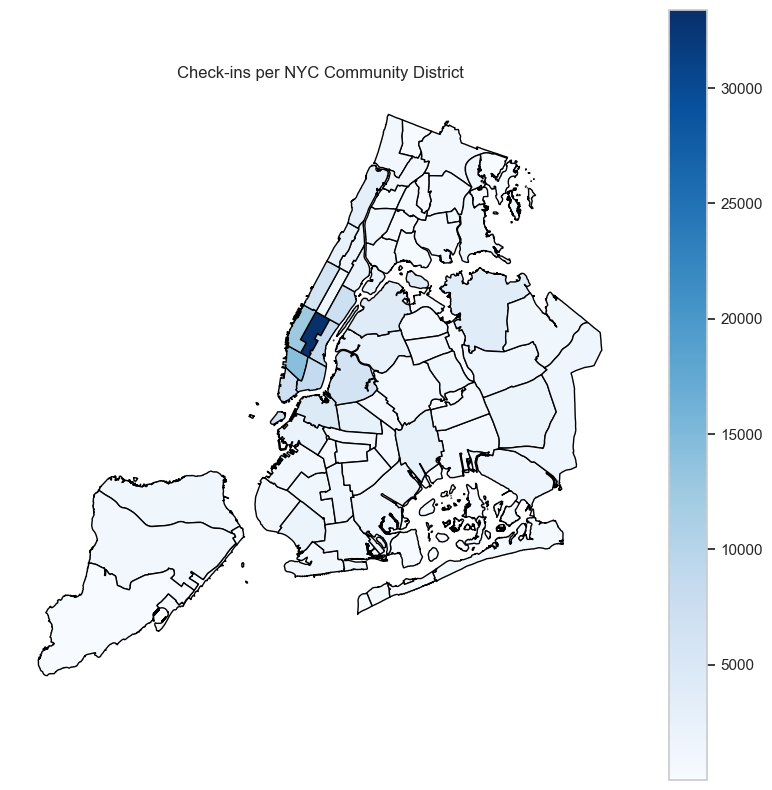

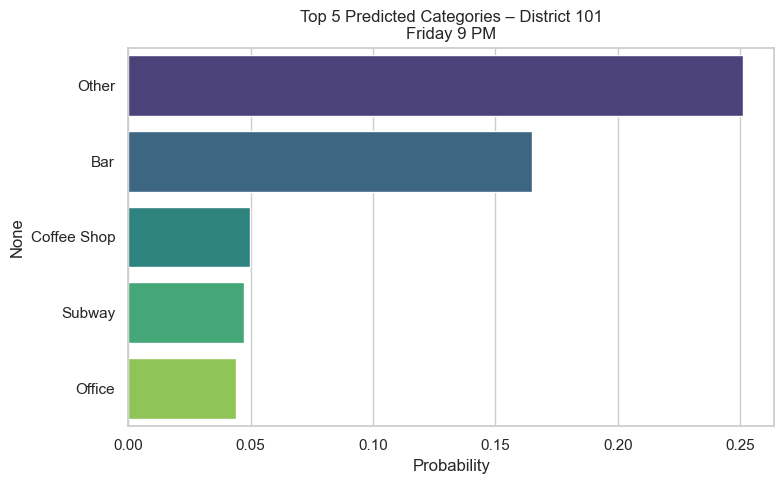

In [ ]:
# ============================================================
# ADDING NYC COMMUNITY DISTRICTS INTO THE PIPELINE (SEPARATE)
# ============================================================

import warnings
warnings.filterwarnings("ignore")

# Libraries
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from shapely.geometry import Point
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

sns.set(style="whitegrid")


# ============================================================
# 0. BASE FUNCTIONS (from your main pipeline)
# ============================================================

def load_raw_data():
    fp = "/Users/chardog234/Documents/GitHub/Final_project_4003/dataset_TSMC2014_NYC.csv"
    df = pd.read_csv(fp, encoding="ISO-8859-1")
    print(f"Loaded {len(df)} rows.")
    return df

def normalize_times(df):
    df = df.copy()
    df["UTC_Time"] = pd.to_datetime(
        df["utcTimestamp"], utc=True,
        format="%a %b %d %H:%M:%S +0000 %Y",
        errors="coerce"
    )
    df = df.dropna(subset=["UTC_Time"])
    df["Local_Time"] = df["UTC_Time"] + pd.to_timedelta(df["timezoneOffset"], unit="m")
    df["Day_of_Week"] = df["Local_Time"].dt.day_name()
    df["Hour"] = df["Local_Time"].dt.hour
    return df

def simplify_categories(df, top_k=30, min_count=50):
    df = df.copy()
    vc = df["venueCategory"].value_counts()
    frequent = vc[vc >= min_count].head(top_k).index
    df["venueCategory_grouped"] = df["venueCategory"].where(
        df["venueCategory"].isin(frequent),
        other="Other"
    )
    print(f"Original categories: {df['venueCategory'].nunique()}")
    print(f"Reduced to {df['venueCategory_grouped'].nunique()} (incl. 'Other')")
    return df


# ============================================================
# 1. LOAD COMMUNITY DISTRICTS SHAPEFILE
# ============================================================
def attach_district_zones(df):
    path = "/Users/chardog234/Downloads/nycd_25d/nycd.shp"
    districts = gpd.read_file(path).to_crs(epsg=4326)
    districts = districts.rename(columns={"BoroCD": "District_ID"})

    gdf = gpd.GeoDataFrame(
        df.copy(),
        geometry=[Point(xy) for xy in zip(df["longitude"], df["latitude"])],
        crs="EPSG:4326"
    )

    joined = gpd.sjoin(
        gdf,
        districts[["District_ID", "geometry"]],
        how="left",
        predicate="within"
    )

    joined = joined.dropna(subset=["District_ID"])
    joined = joined.drop(columns=["index_right"])

    print("Matched", len(joined), "rows to COMMUNITY DISTRICTS")
    return joined, districts


# ============================================================
# 2. BUILD DISTRICT CONTEXT TABLE
# ============================================================
def build_district_contexts(df, alpha=0.3):
    group_cols = ["District_ID", "Day_of_Week", "Hour"]

    counts = (
        df.groupby(group_cols + ["venueCategory_grouped"])
          .size()
          .reset_index(name="freq")
    )

    # Laplace smoothing
    counts["freq_smooth"] = counts["freq"] + alpha
    counts["prob"] = counts["freq_smooth"] / counts.groupby(group_cols)["freq_smooth"].transform("sum")

    pivot = counts.pivot_table(
        index=group_cols,
        columns="venueCategory_grouped",
        values="prob",
        fill_value=0.0
    ).reset_index()

    print("District context rows:", len(pivot))
    return pivot


# ============================================================
# 3. DISTRICT MODEL
# ============================================================
class DistrictModel:
    def __init__(self):
        self.model = None
        self.ohe = None
        self.categories = None

    def fit(self, df_ctx):
        df = df_ctx.copy()

        keys = ["District_ID", "Day_of_Week", "Hour"]
        self.categories = [c for c in df.columns if c not in keys]

        X_raw = df[keys]
        Y = df[self.categories]

        # One-hot encode features
        self.ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
        X_all = self.ohe.fit_transform(X_raw)

        # Stratified split by district
        global DX_train, DX_test, DY_train, DY_test
        global Dpred_train, Dpred_test, D_r2_per_cat

        DX_train, DX_test, DY_train, DY_test = train_test_split(
            X_all, Y,
            test_size=0.2,
            random_state=42,
            stratify=X_raw["District_ID"]
        )

        base = XGBRegressor(
            objective="reg:squarederror",
            n_estimators=700,
            learning_rate=0.05,
            max_depth=10,
            subsample=0.9,
            colsample_bytree=0.9
        )

        self.model = MultiOutputRegressor(base)
        self.model.fit(DX_train, DY_train)

        Dpred_train = self.model.predict(DX_train)
        Dpred_test = self.model.predict(DX_test)

        print("\n===== COMMUNITY DISTRICT MODEL EVALUATION =====")
        print("Train RMSE:", mean_squared_error(DY_train.values.flatten(), Dpred_train.flatten())**0.5)
        print("Test RMSE:", mean_squared_error(DY_test.values.flatten(), Dpred_test.flatten())**0.5)
        print("MAE:", mean_absolute_error(DY_test.values.flatten(), Dpred_test.flatten()))
        print("R²:", r2_score(DY_test.values.flatten(), Dpred_test.flatten()))

        # Per-category R²
        scores = {}
        for i, c in enumerate(self.categories):
            scores[c] = r2_score(DY_test.iloc[:, i], Dpred_test[:, i])
        D_r2_per_cat = pd.Series(scores)

    def predict_distribution(self, district, day, hour, temperature=1.3):
        X_raw = pd.DataFrame([{
            "District_ID": district,
            "Day_of_Week": day,
            "Hour": hour
        }])

        X_enc = self.ohe.transform(X_raw)

        raw = np.maximum(self.model.predict(X_enc)[0], 0)
        raw = raw ** (1/temperature)
        raw /= raw.sum()

        return pd.Series(raw, index=self.categories).sort_values(ascending=False)


# ============================================================
# 4. RUN THE DISTRICT PIPELINE (FIXED)
# ============================================================

df = load_raw_data()
df = normalize_times(df)
df = simplify_categories(df, top_k=30, min_count=50)

# Attach districts
df_districts, district_shapes = attach_district_zones(df)

# Build contexts
df_dist_ctx = build_district_contexts(df_districts)

# Train model
district_model = DistrictModel()
district_model.fit(df_dist_ctx)


# ============================================================
# 5. VISUALIZATIONS
# ============================================================

# ---- District Choropleth ----
district_counts = df_districts.groupby("District_ID").size().reset_index(name="count")
district_plot = district_shapes.merge(district_counts, on="District_ID", how="left")
district_plot["count"] = district_plot["count"].fillna(0)

fig, ax = plt.subplots(figsize=(10, 10))
district_plot.plot(
    ax=ax,
    column="count",
    cmap="Blues",
    legend=True,
    edgecolor="black"
)
plt.title("Check-ins per NYC Community District")
plt.axis("off")
plt.show()


# ---- Top 5 for Friday 9 PM ----
TARGET_DAY = "Friday"
TARGET_HOUR = 21

example_district = 101  # Manhattan CD1 example
pred = district_model.predict_distribution(example_district, TARGET_DAY, TARGET_HOUR)

plt.figure(figsize=(8,5))
sns.barplot(x=pred.head(5).values, y=pred.head(5).index, palette="viridis")
plt.title(f"Top 5 Predicted Categories – District {example_district}\nFriday 9 PM")
plt.xlabel("Probability")
plt.tight_layout()
plt.show()
